In [135]:
from sklearn import tree, metrics
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# load data cleaned from rscript
sc_df = pd.read_csv('../sc_decisions_final.csv')

# drop first col of indexes
sc_df = sc_df.iloc[: , 1:]

# fill missing values as they are legitimate
sc_df = sc_df.fillna("N/A")

sc_df.head()

,c_lcDisagreement,c_lcDispositionDirection,c_issueArea,c_adminActionBool,c_oralArgBool,c_reargBool,c_decisionTime,c_formerCourt,c_caseOriginRegion,c_caseOriginCourt,...,e_decisionPresidentParty,e_JCApproval,j_justiceGender,j_justiceDecisionAgeBand,j_justiceRegion,j_justiceReligion,j_justiceEthnicity,j_justicePresidentParty,j_justiceVotesAppointed,direction
0,0.0,Conservative,Judicial Power,1,1,0,31-180 Days,0,South,District Court,...,Democrat,Approve,Male,65+,Midwest,Lutheran,Caucasian,Republican,<75%,Liberal
1,0.0,Conservative,Judicial Power,1,1,0,31-180 Days,1,South,District Court,...,Democrat,Approve,Male,65+,Midwest,Protestant,Caucasian,Republican,>=75%,Liberal
2,0.0,Conservative,Judicial Power,1,1,0,31-180 Days,0,South,District Court,...,Democrat,Approve,Female,65+,West,N/A,Caucasian,Republican,>=75%,Liberal
3,0.0,Conservative,Judicial Power,1,1,0,31-180 Days,1,South,District Court,...,Democrat,Approve,Male,0-65,Northeast,Catholicism,Caucasian,Republican,>=75%,Conservative
4,0.0,Conservative,Judicial Power,1,1,0,31-180 Days,1,South,District Court,...,Democrat,Approve,Male,0-65,West,Catholicism,Caucasian,Republican,>=75%,Liberal


In [136]:
# select explanatory and response variables
X = sc_df.loc[:, sc_df.columns != 'direction']
y = sc_df[['direction']].astype("category")

# encode target
y = y.apply(lambda x: x.cat.codes)

# check target encoding
# y.apply(lambda x: x.cat.categories) 

# treat booleans and multiple categories differently
cat_vars = list(X.columns[X.nunique() > 2])
bool_vars = list(X.columns[X.nunique() == 2])

# encode categorical features
X_cat = pd.get_dummies(X[cat_vars], columns = cat_vars)
X_bool = pd.get_dummies(X[bool_vars], columns = bool_vars, drop_first = True)
X = pd.concat([X_cat, X_bool], axis = 1)


In [134]:
test = X[['j_justiceReligion_Episcopalian', 'j_justiceReligion_Jewish',
       'j_justiceReligion_Judaism', 'j_justiceReligion_Lutheran',
       'j_justiceReligion_N/A', 'j_justiceReligion_Protestant']]
test[test.sum(axis=1) > 1]

,j_justiceReligion_Episcopalian,j_justiceReligion_Jewish,j_justiceReligion_Judaism,j_justiceReligion_Lutheran,j_justiceReligion_N/A,j_justiceReligion_Protestant


In [137]:
# split into training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)
print("Training split input- ", X_train.shape)
print("Testing split input- ", X_test.shape)

Training split input-  (10535, 60)
Testing split input-  (3512, 60)


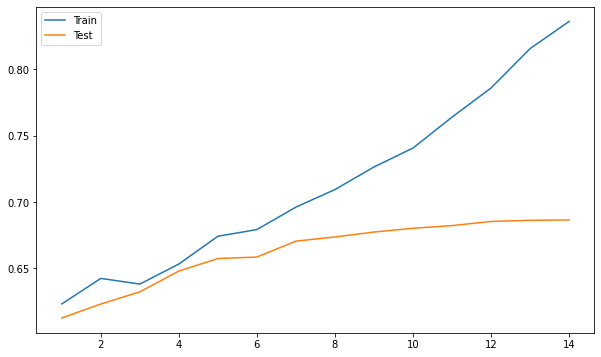

In [138]:
train_scores = []
test_scores = []

# number of trees
depths = [i for i in range(1, 15)] 

# evaluate forest per num trees
for i in depths:
    model = RandomForestClassifier(max_depth=i, n_jobs=-1)
    model.fit(X_train, np.ravel(y_train))
    
    # evaluate train dataset
    yhat_train = model.predict(X_train)
    train_accuracy = metrics.accuracy_score(y_train, yhat_train)
    train_scores.append(train_accuracy)
    
    # evaluate test dataset
    yhat_test = model.predict(X_test)
    test_accuracy = metrics.accuracy_score(y_test, yhat_test)
    test_scores.append(test_accuracy)


# plot training and test results
plt.figure(figsize=(10,6)) 
plt.plot(depths, train_scores, label='Train')
plt.plot(depths, test_scores, label='Test')
plt.legend()
plt.savefig('max_depth_forest.png')

# around 6

In [112]:
# wide range considerations for hyperparameters

# num trees in forest
n_estimators = list(range(100, 1000+1, 100))

# num features to consider at every split
max_features = ['auto', 'sqrt']

# max depth of each tree
#max_depth = [i for i in range(1, 10)] # should be around 4-6 since overfitting afterwards, so limit range
max_depth = [6]

# min num samples to split a node
min_samples_split = [2, 5, 10]

# min num samples at each leaf node
min_samples_leaf = [2, 4, 6, 8, 10]

# whether bootstrap samples are used
bootstrap = [True, False]

# random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [6], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [2, 4, 6, 8, 10], 'bootstrap': [True, False]}


In [118]:
from sklearn.model_selection import RandomizedSearchCV

# tune with randomized grid search
model = RandomForestClassifier()

# random search of parameters with 3 fold CV
model_random = RandomizedSearchCV(estimator = model, param_distributions = random_grid, n_iter = 100, cv = 3,
                                  verbose=2, random_state=42, n_jobs = -1)
# fit the random search model
model_random.fit(X_train, np.ravel(y_train))

model_random.best_params_ # these are narrowed down possible parameter values

Fitting 3 folds for each of 100 candidates, totalling 300 fits


{'n_estimators': 600,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 6,
 'bootstrap': True}

In [119]:
 def evaluate(model, x, y):
    y_hat = model.predict(x)
    accuracy = metrics.accuracy_score(y, y_hat)
    return accuracy
    
# evaluate best random model
best_random = model_random.best_estimator_
random_acc = evaluate(best_random, X_test, y_test)
print(random_acc)

0.6511958997722096


In [131]:
# base model
base_model = RandomForestClassifier(random_state = 42, max_depth = 6)
base_model.fit(X_train, np.ravel(y_train))
base_acc = evaluate(base_model, X_test, y_test)
print(base_acc)

0.6534738041002278


In [132]:
print('Improvement of {:0.2f}%.'.format(100 * (random_acc - base_acc) / base_acc)) # (new - old)/old

Improvement of -0.35%.
[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=10, min_samples_split=15, n_estimators=900; total time=   3.4s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=300; total time=   1.2s
[CV] END bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=300; total time=   1.4s
[CV] END bootstr

[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=8, min_samples_split=15, n_estimators=300; total time=   0.7s
[CV] END bootstrap=False, max_depth=5, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   1.2s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=800; total time=   2.0s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=400; total time=   0.7s
[CV] END bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=800; total time=   3.0s
[CV] END bootstrap=True, max_depth=4, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   0.7s
[CV] END bootstrap=False, max_depth=2, max_feat

[CV] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   0.6s
[CV] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=10, min_samples_split=15, n_estimators=900; total time=   3.4s
[CV] END bootstrap=False, max_depth=3, max_features=auto, min_samples_leaf=10, min_samples_split=5, n_estimators=200; total time=   0.4s
[CV] END bootstrap=True, max_depth=2, max_features=sqrt, min_samples_leaf=6, min_samples_split=15, n_estimators=400; total time=   0.7s
[CV] END bootstrap=True, max_depth=11, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=800; total time=   3.0s
[CV] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max_features=auto, min_samples_leaf=2, min_samples_split=10, n_estimators=900; total time=   1.6s
[CV] END bootstrap=True, max_depth=10, max_

[CV] END bootstrap=False, max_depth=4, max_features=sqrt, min_samples_leaf=4, min_samples_split=5, n_estimators=200; total time=   0.5s
[CV] END bootstrap=True, max_depth=11, max_features=sqrt, min_samples_leaf=10, min_samples_split=15, n_estimators=900; total time=   3.3s
[CV] END bootstrap=True, max_depth=5, max_features=auto, min_samples_leaf=8, min_samples_split=5, n_estimators=800; total time=   2.1s
[CV] END bootstrap=True, max_depth=13, max_features=auto, min_samples_leaf=6, min_samples_split=15, n_estimators=300; total time=   1.2s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END bootstrap=False, max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=5, n_estimators=200; total time=   0.6s
[CV] END bootstrap=False, max_depth=6, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=600; total time=   1.8s
[CV] END bootstrap=True, max_depth=2, max_feat

[CV] END bootstrap=True, max_depth=1, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=400; total time=   0.7s
[CV] END bootstrap=False, max_depth=2, max_features=sqrt, min_samples_leaf=8, min_samples_split=10, n_estimators=700; total time=   1.2s
[CV] END bootstrap=True, max_depth=5, max_features=sqrt, min_samples_leaf=6, min_samples_split=10, n_estimators=1000; total time=   2.6s
[CV] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=200; total time=   0.9s
[CV] END bootstrap=True, max_depth=6, max_features=sqrt, min_samples_leaf=4, min_samples_split=15, n_estimators=400; total time=   1.1s
[CV] END bootstrap=False, max_depth=13, max_features=auto, min_samples_leaf=6, min_samples_split=10, n_estimators=300; total time=   1.5s
[CV] END bootstrap=False, max_depth=11, max_features=sqrt, min_samples_leaf=10, min_samples_split=5, n_estimators=300; total time=   1.3s
[CV] END bootstrap=True, max_depth=2, max

In [122]:
from sklearn.model_selection import GridSearchCV

# further narrow down values of hyperparameters
# random search should be giving us good approximation

# create parameter grid
param_grid = {
    'bootstrap': [True],
    'max_depth': [5, 6, 7], # over 7 is worrisome for overfitting reasons
    'max_features': ['auto'],
    'min_samples_leaf': [2, 4, 6],
    'min_samples_split': [5, 10, 15, 20],
    'n_estimators': [500, 600, 700]
}

print(param_grid)

{'bootstrap': [True], 'max_depth': [5, 6, 7], 'max_features': ['auto'], 'min_samples_leaf': [2, 4, 6], 'min_samples_split': [5, 10, 15, 20], 'n_estimators': [500, 600, 700]}


In [123]:
# create a new model
model_new = RandomForestClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = model_new, param_grid = param_grid,cv = 3, 
                           n_jobs = -1, verbose = 2)

# fit grid search to the data
grid_search.fit(X_train, np.ravel(y_train))

grid_search.best_params_

Fitting 3 folds for each of 108 candidates, totalling 324 fits


{'bootstrap': True,
 'max_depth': 7,
 'max_features': 'auto',
 'min_samples_leaf': 2,
 'min_samples_split': 10,
 'n_estimators': 700}

In [124]:
best_grid = grid_search.best_estimator_
grid_acc = evaluate(best_grid, X_test, y_test)
print(grid_acc)

print('Improvement of {:0.2f}%.'.format( 100 * (grid_acc - base_acc) / base_acc))

0.6574601366742597
Improvement of 0.61%.


In [125]:
yhat_train = best_grid.predict(X_train)
train_accuracy = metrics.accuracy_score(y_train, yhat_train)
print(train_accuracy)

yhat_test = best_grid.predict(X_test)
test_accuracy = metrics.accuracy_score(y_test, yhat_test)
print(test_accuracy)

0.6819174181300427
0.6574601366742597


In [133]:
plt.figure(figsize=(200,120)) 
plot_tree(best_grid[0], feature_names = X.columns, 
          class_names =["Conservative", "Liberal"] , filled = True , precision = 4, rounded = True)
plt.savefig('first_rf_tree.png')

In [127]:
# Feature importances
importances = best_grid.feature_importances_

pd.DataFrame(data = {
    'feature': X.columns,
    'importance': importances
}).sort_values("importance", ascending = False).head(5)

,feature,importance
2,c_lcDispositionDirection_Liberal,0.300373
49,j_justicePresidentParty_Republican,0.079571
36,j_justiceReligion_Protestant,0.058083
40,c_oralArgBool_1,0.046146
47,j_justiceGender_Male,0.044067


**Ignore cells below, just left for backup**

In [128]:
# ignore
forest = RandomForestClassifier(
    bootstrap= False,
    max_depth= 10,
    max_features= 'sqrt',
    min_samples_leaf= 2,
    min_samples_split= 10,
    n_estimators= 400
)


In [ ]:
# resources
# https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
# https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d
# https://www.analyticsvidhya.com/blog/2020/03/beginners-guide-random-forest-hyperparameter-tuning/